<a href="https://colab.research.google.com/github/Willyzw/SuperPointPretrainedNetwork/blob/master/superpoint_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superpoint Handson
This demo

In [2]:
! git clone https://github.com/Willyzw/SuperPointPretrainedNetwork
% cd /content/SuperPointPretrainedNetwork

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 89 (delta 2), reused 5 (delta 1), pack-reused 81
Unpacking objects: 100% (89/89), done.
/content/SuperPointPretrainedNetwork


In [3]:
import time
import numpy as np
import cv2
import PIL.Image as pil

from google.colab import files
from IPython.display import clear_output
from demo_superpoint import SuperPointFrontend, PointTracker, VideoStreamer, myjet

In [4]:
# This class helps load input images from different sources.
vs = VideoStreamer("assets/nyu_snippet.mp4", camid=0, height=480, width=640, skip=1, img_glob='*.png')

print('==> Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path='superpoint_v1.pth',
                        nms_dist=4,
                        conf_thresh=0.015,
                        nn_thresh=0.7,
                        cuda=False)
print('==> Successfully loaded pre-trained network.')

# This class helps merge consecutive point matches into tracks.
tracker = PointTracker(5, nn_thresh=fe.nn_thresh)

==> Processing Video Input.
==> Loading pre-trained network.
==> Successfully loaded pre-trained network.


Processed image 30 (net+post_process: 1.29 FPS, total: 1.13 FPS).


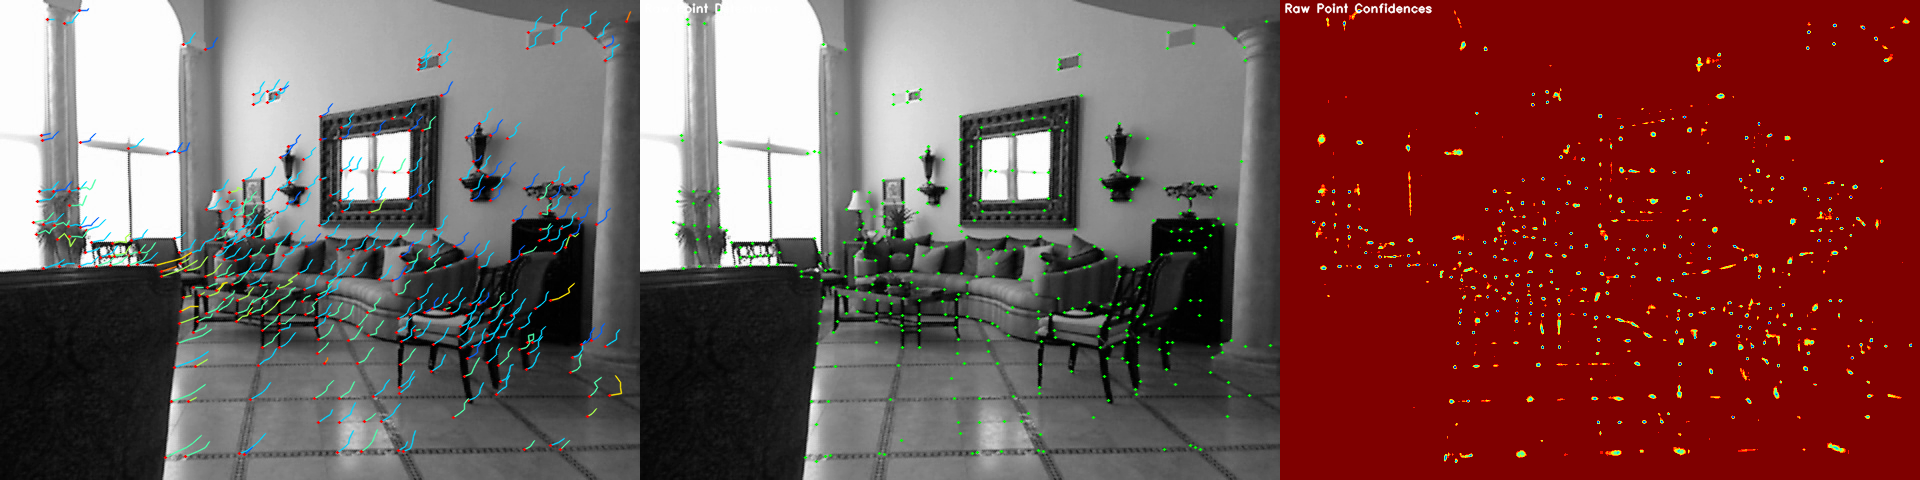

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
vs.reset()
print('==> Running Demo.')

output_file = "demo.avi"
video = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'XVID'), 3.0, (640*3,480))
while True:
  start = time.time()

  # Get a new image.
  img, status = vs.next_frame()
  if status is False:
    break

  # Get points and descriptors.
  start1 = time.time()
  pts, desc, heatmap = fe.run(img)
  end1 = time.time()

  # Add points and descriptors to the tracker.
  tracker.update(pts, desc)

  # Get tracks for points which were match successfully across all frames.
  tracks = tracker.get_tracks(2)

  # Primary output - Show point tracks overlayed on top of input image.
  out1 = (np.dstack((img, img, img)) * 255.).astype('uint8')
  tracks[:, 1] /= float(fe.nn_thresh) # Normalize track scores to [0,1].
  tracker.draw_tracks(out1, tracks)

  # Extra output -- Show current point detections.
  out2 = (np.dstack((img, img, img)) * 255.).astype('uint8')
  for pt in pts.T:
    pt1 = (int(round(pt[0])), int(round(pt[1])))
    cv2.circle(out2, pt1, 1, (0, 255, 0), -1, lineType=16)
  cv2.putText(out2, 'Raw Point Detections', (4, 12), cv2.FONT_HERSHEY_DUPLEX, 0.4, (255, 255, 255), lineType=16)

  # Extra output -- Show the point confidence heatmap.
  min_conf = 0.001
  heatmap[heatmap < min_conf] = min_conf
  heatmap = -np.log(heatmap)
  heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + .00001)
  out3 = myjet[np.round(np.clip(heatmap*10, 0, 9)).astype('int'), :]
  out3 = (out3*255).astype('uint8')
  cv2.putText(out3, 'Raw Point Confidences', (4, 12), cv2.FONT_HERSHEY_DUPLEX, 0.4, (255, 255, 255), lineType=16)

  # Compute runtime
  end = time.time()
  net_t = (1./ float(end1 - start))
  total_t = (1./ float(end - start))

  # Print and show result image
  clear_output(wait=True)
  print('Processed image %d (net+post_process: %.2f FPS, total: %.2f FPS).'\
        % (vs.i, net_t, total_t))
  out = np.hstack((out1, out2, out3))
  display(pil.fromarray(out))
  video.write(out)

files.download(output_file)